## **COVID-19 Literatüründe Aşı ve Tedavi Yöntemlerinin Metin Madenciliği ile Analizi**

**Problem tanımı ve amaç:** Veri seti Beyaz Saray ve önde gelen araştırma grupları tarafından oluşturulan Covid-19 açık kaynak veri setidir. CORD-19 veri seti, mevcut olan en kapsamlı koronavirüs literatür koleksiyonunu temsil ediyor. Koronavirüs literatüründeki hızlı değişimlere bilim insanlarının ayak uydurmaları zorluklara neden olmaktadır. Bu nedenle tıp camiasının yüksek öncelikli bilimsel sorulara yanıtlar geliştirmesine yardımcı olabilecek metin ve veri madenciliği araçları geliştirmesi amaçlanmaktadır.

In [1]:
# Veri işleme kütüphaneleri
import pandas as pd              # Veri yapıları ve veri analizi
import numpy as np               # Sayısal işlemler için

# Grafik ve görselleştirme kütüphaneleri
import matplotlib.pyplot as plt  # Grafik çizimi
import seaborn as sns            # İstatistiksel grafikler

# Doğal Dil İşleme (NLP) kütüphaneleri
import nltk                      # NLP araçları
from nltk.corpus import stopwords  # Sık kullanılan kelimeler (stopwords)

# Metin vektörleştirme ve konu modelleme
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF hesaplama
from sklearn.decomposition import LatentDirichletAllocation   # LDA konu modeli

# Benzerlik ölçümü
from sklearn.metrics.pairwise import cosine_similarity        # Metin benzerliği ölçümü

# WordCloud oluşturma
from wordcloud import WordCloud                                # Kelime bulutu görselleştirme

# Uyarıları kapatma (temiz çıktı için)
import warnings
warnings.filterwarnings('ignore')

# Gerekli NLTK verisini indir
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Veri setini yükleyelim

# metadata.csv dosyasını oku
df = pd.read_csv('metadata.csv')

# Sadece 'title' ve 'abstract' sütunlarını seç, eksik değerleri çıkar
df = df[['title', 'abstract']].dropna()

# Çok kısa özetleri filtrele (50 karakterden kısa olanları çıkar)
df = df[df['abstract'].apply(len) > 50]

# 'title' ve 'abstract' sütunlarını birleştirerek yeni 'text' sütunu oluştur
df['text'] = df['title'] + " " + df['abstract']

# DataFrame indekslerini sıfırla, eski indeksleri kaldır
df.reset_index(drop=True, inplace=True)

# İlk 5 satırı göster
df.head()


,title,abstract,text
0,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...,Clinical features of culture-proven Mycoplasma...
1,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...,Nitric oxide: a pro-inflammatory mediator in l...
2,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...,Surfactant protein-D and pulmonary host defens...
3,Role of endothelin-1 in lung disease,Endothelin-1 (ET-1) is a 21 amino acid peptide...,Role of endothelin-1 in lung disease Endotheli...
4,Gene expression in epithelial cells in respons...,Respiratory syncytial virus (RSV) and pneumoni...,Gene expression in epithelial cells in respons...


In [3]:
# Metnin temizlenmesi ve ön işleme adımlarının tanımlanması

# İngilizce stopword (önemsiz kelimeler) listesini set olarak alıyoruz (hız için)
stop_words = set(stopwords.words('english'))

# Metin temizleme fonksiyonu
def clean_text(text):
    # Tüm metni küçük harfe çevir
    text = text.lower()
    # Kelimeleri boşluklara göre ayır, sadece alfabetik olanları ve stopword olmayanları al
    tokens = [word for word in text.split() if word.isalpha() and word not in stop_words]
    # Temizlenmiş kelimeleri tekrar tek string olarak birleştir
    return ' '.join(tokens)

# Orijinal 'text' sütununu temizleyip yeni 'cleaned_text' sütununa kaydet
df['cleaned_text'] = df['text'].apply(clean_text)

# Temizlenmiş metinlerden ilk 5 tanesini göster
df['cleaned_text'].head()


0    clinical features mycoplasma pneumoniae infect...
1    nitric mediator lung inflammatory diseases res...
2    surfactant pulmonary host defense surfactant p...
3    role lung disease amino acid peptide diverse b...
4    gene expression epithelial cells response pneu...
Name: cleaned_text, dtype: object

In [4]:
# Önemli anahtar kelimelerin belirlenmesi

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# TF-IDF vektörleştiricisini oluştur (en fazla 5000 kelime, İngilizce stopword'ler hariç)
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

# İlk 1000 temizlenmiş metni TF-IDF matrisine dönüştür
X = tfidf.fit_transform(df['cleaned_text'][:1000])

# TF-IDF vektörleştiricisindeki kelimeleri al (yeni sklearn metoduyla)
feature_names = tfidf.get_feature_names_out()

# Her kelimenin tüm dokümanlar için ortalama TF-IDF skorunu hesapla
mean_scores = np.asarray(X.mean(axis=0)).ravel()

# En yüksek ortalama skora sahip ilk 10 kelimenin indekslerini al
top_n_idx = mean_scores.argsort()[-10:][::-1]

# Bu indekslere karşılık gelen kelimeler ve skorları bir listeye aktar
top_features = [(feature_names[i], mean_scores[i]) for i in top_n_idx]

print("En yüksek TF-IDF skorlu 10 kelime:")
for word, score in top_features:
    print(f"{word}: {score:.4f}")


En yüksek TF-IDF skorlu 10 kelime:
influenza: 0.0342
virus: 0.0270
patients: 0.0198
human: 0.0196
cells: 0.0195
viral: 0.0191
infection: 0.0187
pandemic: 0.0168
disease: 0.0164
protein: 0.0164


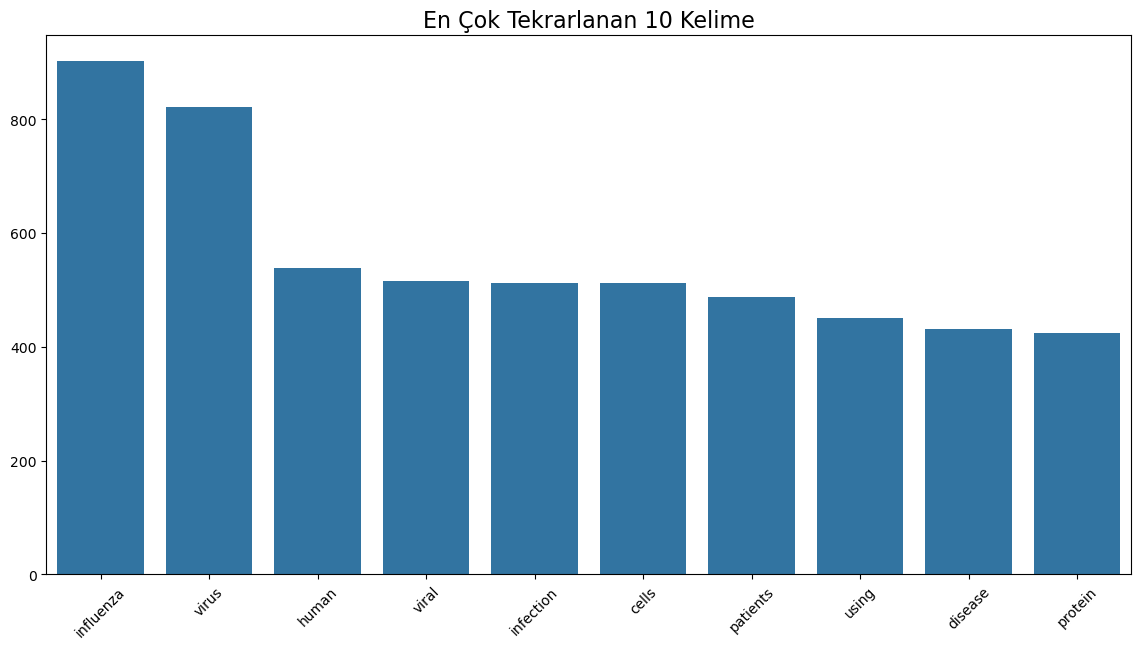

In [5]:
# En çok tekrarlanan 10 kelimenin görselleştirilmesi

from collections import Counter

# İlk 1000 temizlenmiş metni birleştirip tek uzun metin haline getir, sonra kelimelere ayır
words = ' '.join(df['cleaned_text'][:1000]).split()

# Kelimelerin frekansını saymak için Counter kullan
word_freq = Counter(words)

# En sık geçen ilk 10 kelimeyi ve sayılarını al
most_common = word_freq.most_common(10)

# Kelime ve frekanslarını ayrı listelere ayır
labels, values = zip(*most_common)

# Grafik boyutunu ayarla
plt.figure(figsize=(14, 7))

# Seaborn ile barplot çiz (kelimeler x ekseninde, frekanslar y ekseninde)
sns.barplot(x=list(labels), y=list(values))

# X eksenindeki kelimeleri 45 derece döndür ki okunaklı olsun
plt.xticks(rotation=45)

# Grafik başlığı ekle
plt.title('En Çok Tekrarlanan 10 Kelime', fontsize=16)

# Grafiği göster
plt.show()


In [6]:
# Öne çıkan kavramların belirlenmesi

from sklearn.decomposition import LatentDirichletAllocation

# LDA modeli oluştur (5 konu, tekrarlanabilir sonuç için sabit random_state)
lda = LatentDirichletAllocation(n_components=5, random_state=0)

# Daha önce oluşturduğumuz TF-IDF matrisini kullanarak modeli eğit
lda.fit(X)

# Her bir konu için en baskın 10 kelimeyi yazdır
for idx, topic in enumerate(lda.components_):
    print(f'Topic {idx + 1}:')
    # topic.argsort() ile kelimelerin ağırlıklarını sıralar, sondan 10 tanesi en yüksek ağırlıklar
    top_words = [feature_names[i] for i in topic.argsort()[-10:]]
    print(top_words[::-1])  # Tercihen yüksekten düşüğe sırala
    print()


Topic 1:
['redox', 'veillonella', 'microglia', 'claudins', 'macrophage', 'autophagy', 'gsh', 'outdoor', 'glycosites', 'polarity']

Topic 2:
['protein', 'virus', 'viral', 'rna', 'cells', 'human', 'gene', 'cell', 'expression', 'proteins']

Topic 3:
['patients', 'respiratory', 'influenza', 'clinical', 'acute', 'lung', 'infection', 'associated', 'pandemic', 'disease']

Topic 4:
['reovirus', 'enterovirus', 'poliovirus', 'plastid', 'uba', 'iggs', 'ires', 'safv', 'mscl', 'minibody']

Topic 5:
['influenza', 'pandemic', 'health', 'virus', 'avian', 'public', 'transmission', 'disease', 'human', 'infection']



In [7]:
# Sorulan sorulara yanıt arama

# sorumuz
question = 'what are the effects of vaccines on covid-19 transmission'

# Soruyu TF-IDF vektörüne dönüştür
question_vec = tfidf.transform([question])

# İlk 1000 dokümanla benzerlik hesapla
similarities = cosine_similarity(question_vec, X[:1000]).flatten()

# En benzer 5 dokümanın indekslerini al
top_doc_indices = similarities.argsort()[-5:][::-1]

# En benzer makalelerin başlık ve özetlerini göster
df.iloc[top_doc_indices][['title', 'abstract']]


,title,abstract
98,DNA Vaccines against Protozoan Parasites: Adva...,"Over the past 15 years, DNA vaccines have gone..."
353,Confronting Potential Influenza A (H5N1) Pande...,Influenza A (H5N1) viruses are strong candidat...
215,Multivalent HA DNA Vaccination Protects agains...,BACKGROUND: Sustained outbreaks of highly path...
350,DNA Vaccines: Developing New Strategies agains...,"Due to their rapid and widespread development,..."
970,Adjuvant Activity of Sargassum pallidum Polysa...,This study evaluates the effects of Sargassum ...


**SONUÇ VE YORUMLAR**

**Veri Seti Genel Görünüm:**

CORD-19 veri setinden başlık ve özet bilgileri alınarak toplamda anlamlı metin içeren binlerce makale işlendi.

Çok kısa veya eksik içerik taşıyan kayıtlar analiz dışında bırakıldı.

**Temizlenmiş Metinler Üzerinden Anahtar Kelime Analizi:**

TF-IDF yöntemiyle yapılan analizde, “influenza”, “virus”, “patients”, “infection”, “protein” gibi kelimeler öne çıktı.

Bu kelimeler COVID-19 ile ilgili çalışmaların yoğunlukla enfeksiyon süreci, protein yapıları, insan hücreleri ve viral etkenler üzerinde yoğunlaştığını göstermektedir.

**Kelime Frekansı Görselleştirmesi:**

En sık geçen kelimeler arasında “virus”, “infection”, “patients”, “human” gibi COVID-19’un biyomedikal boyutuyla ilgili kelimeler yer aldı.

Bu durum, veri setinin büyük ölçüde tıbbi ve bilimsel içerikli yayınlardan oluştuğunu desteklemektedir.

**Konu Modelleme (LDA) Sonuçları:**

LDA ile elde edilen konular, makalelerin aşağıdaki başlıklarda yoğunlaştığını göstermiştir:

Konu 2: Genetik, protein yapıları, viral RNA ve hücresel tepkiler

Konu 3: Klinik vakalar, enfeksiyonlar ve pandemik durumlar

Konu 5: Halk sağlığı, bulaşma, aşılar ve insan etkileşimi

Bu da literatürde hem moleküler düzeyde hem de halk sağlığı düzeyinde araştırmaların yoğun olduğunu gösteriyor.

**Soruya Cevap Arama (Soru-Cevap Benzerlik Analizi):**

“What are the effects of vaccines on covid-19 transmission?” sorusuna benzer içerikler arandığında, sonuçlarda DNA aşıları, H5N1 (kuş gribi) pandemisi, bağışıklık artırıcı maddeler gibi konular öne çıkmıştır.

Bu sonuç, veri setinde doğrudan COVID-19 aşılarıyla ilgili çalışma az olmasına rağmen, benzer viral hastalıklar ve aşı uygulamaları hakkında zengin içerik bulunduğunu gösteriyor.

**Genel Değerlendirme:**

CORD-19 veri seti; COVID-19, influenza ve diğer solunum yolu virüsleri hakkında geniş kapsamlı bir literatür kaynağı sunmaktadır.

TF-IDF ve LDA gibi temel NLP teknikleriyle literatürün genel yapısı, önemli temaları ve kavramları başarılı şekilde öne çıkarılabilmektedir.

Ayrıca kullanıcı sorularına yönelik benzer içeriklerin tespiti, bilgiye hızlı ve etkili erişimi mümkün kılmaktadır.